<p style="text-align: center;"><span style="color: #ff0000;"><strong><span style="font-size: x-large;">
    ANEXO III: PROBLEMAS RELACIONADOS CON RETICULOS</span></strong></span></p>

<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Realizado por:</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Gabriel Vacaro Goytia</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Ignacio Warleta Murcia</span></strong></span></p>

Después de haber analizado cuidadosamente los problemas más relevantes relacionados con retículos, en este anexo procederemos a estudiar su funcionameinto de manera práctica, explicando paso a paso cada una de las fases que lo componen. En concreto, se han desarrollado implementaciones para ilustrar los problemas hallados en el documento principal, como son el CVP, el SVP y el LWE. Para ello se ha hecho uso de la librería LattPy entre otras, utilizada y explicada en el anexo II.

Organizamos el anexo según el siguiente índice:

# Índice

1. [Introducción](#1.-Introducción)
2. [Configuración previa](#2.-Configuración-previa)
3. [Problema del vector mas cercano](#3.-CVP)
4. [Problema del vector mas corto](#4.-SVP)
5. [Aprendizaje con errores](#5.-LWE)

---
# 1. Introducción


En este anexo se presentan las implementaciones prácticas de tres problemas fundamentales en el ámbito de la criptografía post-cuántica: el Problema del Vector Más Cercano (**CVP**, por sus siglas en inglés), el Problema del Vector Más Corto (**SVP**) y el Problema de Aprendizaje con Errores (**LWE**). Estos problemas son pilares matemáticos sobre los que se construyen diversos esquemas criptográficos modernos debido a su elevada complejidad computacional y a su resistencia frente a ataques con computadoras cuánticas. A lo largo de este anexo, se detalla cómo se han implementado estos problemas, proporcionando un análisis del diseño de los algoritmos, los métodos de optimización utilizados y los resultados obtenidos en diferentes escenarios prácticos. 



# 2. Configuración previa

In [4]:
#MODULOS A IMPORTAR
import numpy as np
import lattpy as lp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import time 
import random

In [33]:
#FUNCIONES UTILIZADAS

def add_atom(latt, num_atoms, dim):
    """
    Crea átomos en la red con posiciones aleatorias y únicas, esto se traducirá en nuevas capas por cada átomo añadido.
    
    Parámetros:
    - latt: reticulo donde se agregarán los átomos.
    - num_atoms: número de átomos a crear.
    - dim: número de dimensiones del espacio.

    Retorna:
    - None
    """
    # Crear un conjunto para asegurarnos de que las posiciones sean únicas
    generated_positions = set()

    #Mientras que haya menos posiciones que numero de atomos a crear:
    while len(generated_positions) < num_atoms:
        # Generar coordenadas aleatorias en [0, 1) para todas las dimensiones
        coords = tuple(np.random.rand(dim)) # Ejemplo con dim = 5: coords = [0.12 0.45 0.67 0.89 0.23]
        generated_positions.add(coords)  

    # Agregar átomos generados a al red
    for i, coords in enumerate(generated_positions):
        name = f"Atom_{i + 1}"  # Nombra los átomos de forma automática
        latt.add_atom(list(coords), name)

# Función para generar los puntos del retículo
def generate_lattice_points(base, limit):
    """
    Genera todos los puntos del retículo dados los vectores base y un límite 
    (es necesario acotar el retículo para que sea computacionalmente viable).

    Parámetros:
    - base: vectores iniciales que generan el retículo.
    - limit: rango de los valores enteros para las combinaciones.

    Retorna:
    - Array con todos los puntos del retículo.
    """
    # Generamos todas las combinaciones posibles de los enteros para [-limit,limit]
    combinations_k = list(product(range(-limit, limit + 1), repeat=base.shape[0])) # Ejemplo con base 1 dimensional y limite 1:
                                                                                   # [(-1,), (0,), (1,)]

    # Generamos los puntos del retículo como combinaciones lineales de los vectores base
    # Ejemplo: si k = (1, -1) y base = [[1, 0], [0, 1]], entonces point = [1, -1]
    lattice_points = []
    for k in combinations_k:
        point = sum(k[i] * base[i] for i in range(len(k)))
        lattice_points.append(point)
     
    return np.array(lattice_points)


def generate_lattice_points_LWE(dim, q):
        """
        Genera puntos del retículo en el espacio de búsqueda [0,q-1], se diferencia a la anterior en que esta
        función esta pensada explicitamente para algoritmos módulo q y con bases ortogonales.

        Parámetros:
        - dim: dimensión del espacio.
        - q: módulo.

        Retorna:
        - lattice_points: lista de puntos del retículo.
        """
        return list(itertools.product(range(q), repeat=dim))


---

# 3. CVP

En un retículo $L$, el problema del vector más cercano consiste en encontrar un vector $v∈L$ que esté más cerca de un punto dado $t∈R^n$ en términos de la norma euclidiana. Formalmente, se busca: 

Encontrar $ v \in L $ que minimice $|v - t|$, siendo:  $v = \arg\min_{w \in L} \|w - t\|.$

En esta implementación, veremos de forma gráfica tanto en 2D como en 3D como se comporta este problema, en caso de querer variar los parámetros, basta con cambiar las variables iniciales:

- num_atoms: determina cuantas redes se formarán (Gran impacto en rendimiento)

- dimensiones: determina el tamaño de la matriz base (Gran impacto en rendimiento, mantener por debajo de 8).

- target_point: determina el punto sobre el que buscar el vector mas cercano

- limite: determina los valores máximos en cada eje (Gran impacto en rendimiento).

- num_conex: determina el numero de conexiones de cada punto del retículo, por ejemplo, si equivale a 2, se conectara a sus dos vecinos más cercanos (Gran impaco en rendimiento).


Por otra parte, el último bloque de código no presenta visualización, pues esta pensado para probar en dimensiones mayores que no pueden ser representadas graficamente, no obstante si presenta una salida con los valores solución del problema.

In [34]:
#Funcion para calcular el vector mas cercano dado un punto
def closestVector(base, limit, lattice_points, target_point):
    """
    Encuentra el vector más cercano desde un punto objetivo (target_point) a todos los puntos del retículo.

    Parámetros:
    - base: vectores iniciales que conforman el retículo.
    - limit: rango máximo de valores en el retículo [-limit, limit].
    - lattice_points: matriz con los puntos del retículo generados.
    - target_point: punto objetivo desde el cual buscar el vector más cercano.
    
    Retorna:
    - el vector más cercano y su norma.
    """
    
    # Inicializar variables para almacenar el mejor vector y su norma más baja
    best_vector = None
    minor_norm = float('inf')

    # Iterar sobre todos los puntos del retículo
    for point in lattice_points:
        if not np.array_equal(point, target_point):  # Evitar el propio punto objetivo
            vector = point - target_point  # Vector entre el punto objetivo y el punto del retículo
            norm = np.linalg.norm(vector)  # Calcular la norma del vector

            # Si encontramos un vector con norma menor, lo actualizamos
            if norm < minor_norm:
                best_vector = vector
                minor_norm = norm
    
    return best_vector, minor_norm

Coordenadas del punto más cercano desde el punto objetivo [6 6]: [5. 5.]
Coordenadas del vector más cercano desde el punto objetivo [6 6]: [-1., -1.]
Norma del vector más cercano: 1.41
Tiempo para encontrar el vector más cercano: 0.00200 segundos


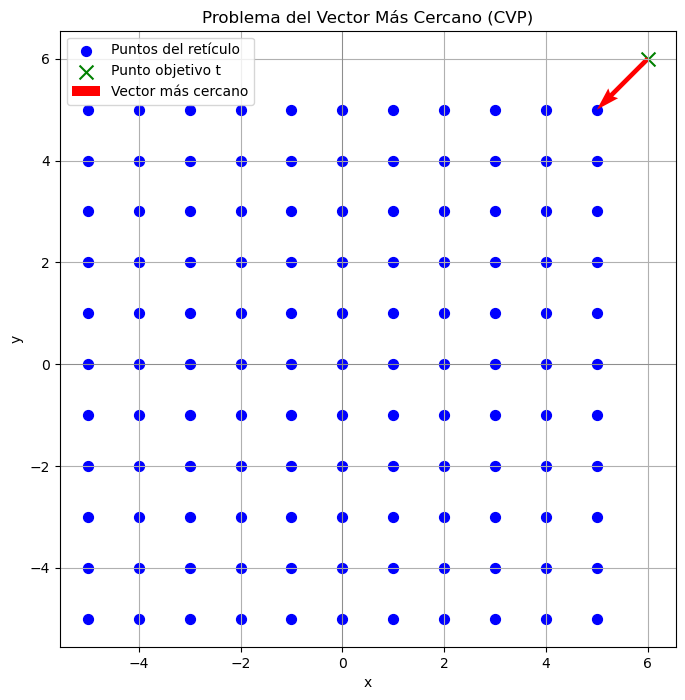

In [35]:
# PROBLEMA DEL CVP 2D

#VARIABLES
num_atoms = 1
dim = 2
target_point = np.array([6,6])  # Punto sobre el que buscar el vector mas cercano
limit = 5
num_conex = 1

base = np.eye(dim)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base) # Crear el retículo con lattpy
add_atom(latt, num_atoms, dim) # Añadir atomos al retículo (generarán nuevas capas en el retículo)
latt.add_connections(num_conex)  # Conexión de los "num_conex" primeros vecinos

# Construir un retículo finito de tamaño limitxlimit (2D)
latt.build((limit, limit))

# Generar puntos del retículo
lattice_points = generate_lattice_points(base, limit)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limit, lattice_points, target_point)
end_time = time.time()

closest_point =  target_point + closest_vector # Viajamos hacia el puinto mas cercano con el vector encontrado.

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del punto más cercano desde el punto objetivo {target_point}: {closest_point}")
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}: {np.array2string(closest_vector, separator=', ')}")
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

# Visualización ----------------------------------------------
plt.figure(figsize=(8, 8))

# Puntos del retículo
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], c="blue", label="Puntos del retículo", s=50)  # Aumentar tamaño de los puntos

# Punto objetivo t
plt.scatter(target_point[0], target_point[1], c="green", label="Punto objetivo t", s=100, marker="x")  # Diferenciar el punto objetivo

# Vector más cercano
plt.quiver(target_point[0], target_point[1], closest_point[0] - target_point[0], closest_point[1] - target_point[1],
           angles='xy', scale_units='xy', scale=1, color="red", label="Vector más cercano")  # Ajuste la escala para la visualización

# Líneas de referencia para los ejes
plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)

# Configurar la vista para que la relación de aspecto sea igual
plt.gca().set_aspect('equal', adjustable='box')

# Agregar leyenda y título
plt.legend()
plt.title("Problema del Vector Más Cercano (CVP)")
plt.xlabel("x")
plt.ylabel("y")

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()


Coordenadas del punto más cercano desde el punto objetivo [6 6 6]: [5. 5. 5.]
Coordenadas del vector más cercano desde el punto objetivo [6 6 6]: [-1., -1., -1.]
Norma del vector más cercano: 1.73
Tiempo para encontrar el vector más cercano: 0.01401 segundos


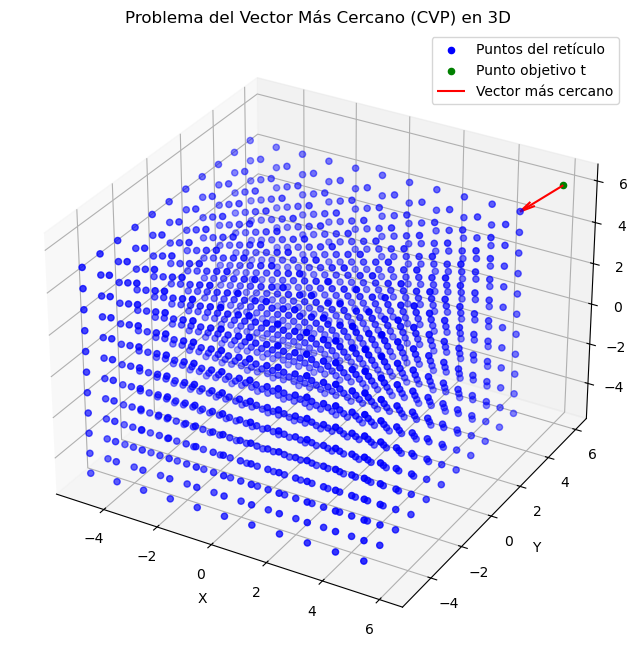

In [36]:
# PROBLEMA DEL CVP 3D
num_atoms = 1
dim = 3
target_point = np.array([6, 6, 6])  # Punto sobre el que buscar el vector más cercano
limit= 5
num_conex = 1


base = np.eye(dim)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base) # Crear el retículo con lattpy
add_atom(latt, num_atoms, dim)
latt.add_connections(num_conex)  # Conexión de los "num_conex" primeros vecinos

# Construir un retículo finito de tamaño limitxlimitxlimit (3D)
latt.build((limit, limit, limit))

# Generar puntos del retículo
lattice_points = generate_lattice_points(base, limit)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limit, lattice_points, target_point)
end_time = time.time()

# Viajamos hacia el puinto mas cercano con el vector encontrado.
closest_point = target_point + closest_vector

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del punto más cercano desde el punto objetivo {target_point}: {closest_point}")
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}: { np.array2string(closest_vector, separator=', ')}")
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

# Visualización en 3D ----------------------------------------------------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Puntos del retículo
ax.scatter(lattice_points[:, 0], lattice_points[:, 1], lattice_points[:, 2], c="blue", label="Puntos del retículo")  # Puntos del retículo
ax.scatter(target_point[0], target_point[1], target_point[2], c="green", label="Punto objetivo t")  # Punto objetivo t

# Vector más cercano
ax.quiver(target_point[0], target_point[1], target_point[2], 
          closest_point[0] - target_point[0], closest_point[1] - target_point[1], closest_point[2] - target_point[2],
          color="red", label="Vector más cercano", length=closest_norm, normalize=True)

# Configurar el gráfico
ax.set_aspect('auto')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.set_title("Problema del Vector Más Cercano (CVP) en 3D")
plt.show()


In [37]:
#PROBLEMA DEL CVP GENERALIZADO

# VARIABLES ( Importante que las coordenadas del punto objetivo se ajusten a las dimensiones)
dim = 6
num_atomos = 1
num_conex = 1
limit = 5
#¡Tiene que coincidir con el numero de dimensiones!
target_point = np.array([1, 0.5, 0.8, 0.1, 0.3, 0.6])  # Ejemplo de un punto objetivo

# Base para el retículo
base = np.eye(dim)  # Matriz identidad para generar base genérica N dimensional

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
add_atom(latt, num_atomos, dim=dim)

# Agregar conexiones a los "num_conex" vecinos mas cercanos
latt.add_connections(num_conex)  

# Construir un retículo finito de tamaño especificado limit con las dimensiones adecuadas.
latt.build((limit,) * dim)

# Generar puntos del retículo
lattice_points = generate_lattice_points(base, limit)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limit, lattice_points, target_point)
end_time = time.time()

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}:")
print("Coordenadas del vector más cercano:", np.array2string(closest_vector, separator=', '))
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

Coordenadas del vector más cercano desde el punto objetivo [1.  0.5 0.8 0.1 0.3 0.6]:
Coordenadas del vector más cercano: [ 0. , -0.5,  0.2, -0.1, -0.3,  0.4]
Norma del vector más cercano: 0.74
Tiempo para encontrar el vector más cercano: 15.97309 segundos


---
# 4. SVP


En un retículo $L$, el problema del vector más corto consiste en encontrar un vector no nulo $v∈L$ que minimice la norma euclidiana $‖v‖$, es decir:

Encontrar $ v \neq 0 $ tal que $ \|v\| = \min_{w \in L, w \neq 0} \|w\|.$

En esta implementación, veremos de forma gráfica tanto en 2D como en 3D como se comporta este problema, en caso de querer variar los parámetros, basta con cambiar las variables iniciales:

- base: en este caso la base no podrá ser una matriz identidad, pues entonces la solución sería trivial.

- num_atoms: determina cuantas redes se formarán (Gran impacto en rendimiento)

- dimensiones: determina el tamaño de la matriz base (Gran impacto en rendimiento, mantener por debajo de 8).

- limite: determina los valores máximos en cada eje (Gran impacto en rendimiento).

- num_conex: determina el numero de conexiones de cada punto del retículo, por ejemplo, si equivale a 2, se conectara a sus dos vecinos más cercanos (Gran impaco en rendimiento).

Por otra parte, el último bloque de código no presenta visualización, pues esta pensado para probar en dimensiones mayores que no pueden ser representadas graficamente, no obstante si presenta una salida con los valores solución del problema.


In [9]:
# Función para calcular el vector más corto entre todos los puntos del retículo
def shortestVector(base, limit, lattice_points):
    """
    Encuentra el vector más corto entre todos los puntos del retículo generado por los vectores base,
    excluyendo el origen. Considera todas las combinaciones posibles de pares de puntos.

    base: matriz de base del retículo.
    limit: rango de los índices.

    Retorna el vector más corto y su norma.
    """
    
    # Inicializar variables para almacenar el mejor vector y su norma más baja
    best_vector = None
    minor_norm = float('inf')

    # Iterar sobre todos los pares de puntos posibles
    for i, point_1 in enumerate(lattice_points):
        for j, point_2 in enumerate(lattice_points):
            if i != j:  # Evitar calcular el vector entre un punto y él mismo
                vector = point_2 - point_1  # Vector entre el par de puntos
                norm = np.linalg.norm(vector)  # Calcular la norma del vector
                
                # Si encontramos un vector con norma menor, lo actualizamos
                if norm < minor_norm:
                    best_vector = vector
                    minor_norm = norm
    
    return best_vector, minor_norm

Coordenadas del vector más corto: [-0.1,  0. ]
Norma del vector más corto: 0.10
Tiempo para encontrar el vector más corto: 0.06826 segundos


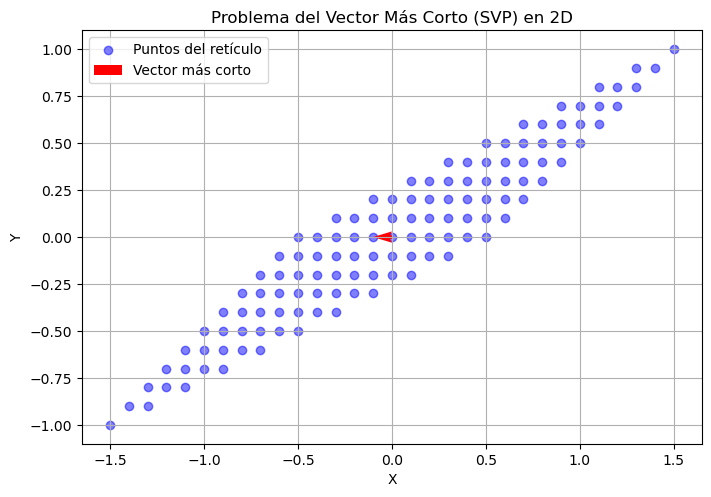

In [10]:
# PROBLEMA DEL SVP (en 2D)
# VARIABLES

dim = 2  # Ahora en 2D
num_atomos = 1
num_conex = 1
limit = 5  # Limite para las combinaciones de los vectores base (por ejemplo, de -5 a 5)

# Base para el retículo (dimensiones generales)
#base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en 2D
base = np.array([[0.1, 0.1],[0.2, 0.1]])

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
add_atom(latt, num_atomos, dim=dim)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limit,) * dim)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
lattice_points = generate_lattice_points(base, limit)

# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
best_vector, minor_norm = shortestVector(base, limit, lattice_points)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(best_vector, separator=', '))
print(f"Norma del vector más corto: {minor_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")

# Visualización en 2D del retículo y el vector más corto
plt.figure(figsize=(8, 8))

# Puntos del retículo
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], c="blue", label="Puntos del retículo", alpha=0.5)

# Vector más corto
plt.quiver(0, 0, best_vector[0], best_vector[1], angles='xy', scale_units='xy', scale=1, color="red", label="Vector más corto", linewidth=2)

# Configurar el gráfico
plt.title("Problema del Vector Más Corto (SVP) en 2D")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()


Coordenadas del vector más corto: [ 0.2      ,  0.2339746, -0.5      ]
Norma del vector más corto: 0.59
Tiempo para encontrar el vector más corto: 9.67421 segundos


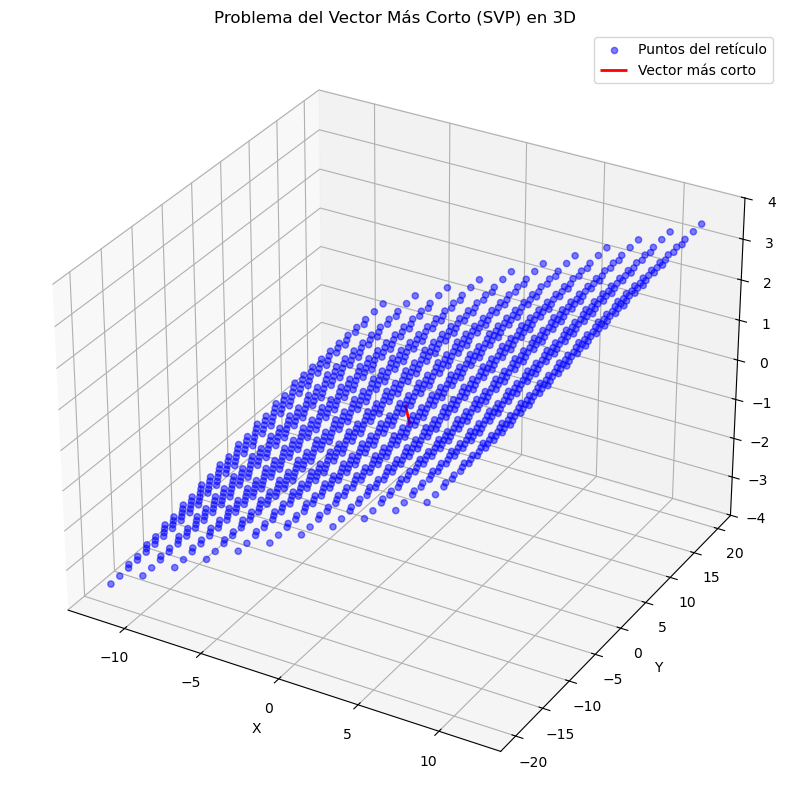

In [11]:
#PROBLEMA DEL SVP EN 3D
# VARIABLES
dim = 3
num_atomos = 1
num_conex = 1
limit = 5  # Limite para las combinaciones de los vectores base (por ejemplo, de -2 a 2)

# Base para el retículo (dimensiones generales)
#base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en N dimensiones
base = np.array([[1.3, 2.1, 0.1], [0.9, np.sqrt(3)/2, 0.5], [0.2, 1, 0.1]])

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
add_atom(latt, num_atomos, dim=dim)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limit,) * dim)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
lattice_points = generate_lattice_points(base, limit)
# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
best_vector, minor_norm =shortestVector(base, limit, lattice_points)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(best_vector, separator=', '))
print(f"Norma del vector más corto: {minor_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")

# Visualización en 3D del retículo y el vector más corto
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Puntos del retículo
ax.scatter(lattice_points[:, 0], lattice_points[:, 1], lattice_points[:, 2], 
           c="blue", label="Puntos del retículo", alpha=0.5)

# Vector más corto
ax.quiver(0, 0, 0, 
          best_vector[0], best_vector[1], best_vector[2], 
          color="red", label="Vector más corto", linewidth=2, arrow_length_ratio=0.1)

# Configurar el gráfico
ax.set_title("Problema del Vector Más Corto (SVP) en 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()



In [12]:
#PROBLEMA DEL SVP GENERALIZADO
# VARIABLES
dim = 3
num_atomos = 1
num_conex = 1
limit = 5

# Base para el retículo (dimensiones generales)
#base = np.eye(dim) 
base = np.array([[1.3, 2.1, 0.1], [0.9, np.sqrt(3)/2, 0.5], [0.2, 1, 0.1]])  # Base de un retículo triangular 3D

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
add_atom(latt, num_atomos, dim=dim)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limit,) * dim)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
lattice_points = generate_lattice_points(base, limit)
# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
best_vector, minor_norm =shortestVector(base, limit, lattice_points)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(best_vector, separator=', '))
print(f"Norma del vector más corto: {minor_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")



Coordenadas del vector más corto: [ 0.2      ,  0.2339746, -0.5      ]
Norma del vector más corto: 0.59
Tiempo para encontrar el vector más corto: 10.40924 segundos


---
# 5. LWE

El Learning with Errors (LWE) es un problema matemático fundamental en criptografía post-cuántica. Se basa en la dificultad de resolver sistemas de ecuaciones lineales con ruido agregado.

Definiremos LWE de la siguiente forma:  
Sean:  
&nbsp;&nbsp;&nbsp;&nbsp;- $p$, un número primo.  
&nbsp;&nbsp;&nbsp;&nbsp;- $n$, la dimensión del espacio.  
&nbsp;&nbsp;&nbsp;&nbsp;- $χ$, una distribución de probabilidad sobre $Z_p$, que genera el ruido $e_i$.  

Se nos da un conjunto de ecuaciones tal que:  

$⟨s,a_1 ⟩ ≈_χ b_1 \ (\text{mod} \ p)$  

$⟨s,a_2 ⟩ ≈_χ b_2 \ (\text{mod} \ p)$  

⋮  

$⟨s,a_m ⟩ ≈_χ b_m \ (\text{mod} \ p)$  

O lo que es equivalente:  
$b_i=⟨s,a_i ⟩+e_i \ \text{mod} \ p; \forall i \in \mathbb{Z}_m$  

Donde:  
&nbsp;&nbsp;&nbsp;&nbsp;$s ∈ Z_p^n$ es el vector secreto que recuperar.  
&nbsp;&nbsp;&nbsp;&nbsp;$a_i ∈ Z_p^n$ son vectores seleccionados de forma uniforme.  
&nbsp;&nbsp;&nbsp;&nbsp;$e_i ∈ Z_p$ es el error añadido generado de acuerdo con $χ$.  
&nbsp;&nbsp;&nbsp;&nbsp;$b_i ∈ Z_p$ es el resultado observado.  


In [13]:
def generate_LWE_samples(secret, num_samples, dim, q, noise_stddev):
    """
    Genera muestras LWE.

    Parámetros:
    - secret: vector secreto.
    - num_samples: número de muestras.
    - dim: dimensión del secreto.
    - q: valor máximo para los vectores 'a' y para las operaciones módulo.
    - noise_stddev: desviación estándar del ruido.

    Retorna:
    - samples: lista de tuplas (a, b).
    """
    samples = []

    for _ in range(num_samples):
        # Generar vector 'a' aleatorio en el rango [-q, q]
        a = [random.randint(0, q) for _ in range(dim)]

        # Calcular b = a . s + e
        b = sum(a[i] * secret[i] for i in range(dim))+q % q

        # Añadir ruido aleatorio en el rango [-noise_stddev, noise_stddev]
        error = random.randint(-noise_stddev, noise_stddev)
        b = (b + error+q) % q

        # Agregar la muestra a la lista
        samples.append((a, b))

    return samples

def solve_LWE(samples, lattice_points, q, noise_stddev):
    """
    Resuelve LWE buscando entre los puntos del retículo.

    Parámetros:
    - samples: lista de tuplas (a, b).
    - lattice_points: puntos del retículo.
    - q: valor máximo para las operaciones módulo.
    - noise_stddev: tolerancia de ruido.

    Retorna:
    - solution: vector secreto aproximado o None si no se encuentra solución.
    """
    dim = len(lattice_points[0])

    while True:
        try:
            for candidate in lattice_points:
                valid = True

                for a, b in samples:
                    computed = sum(a[j] * candidate[j] for j in range(dim))+q % q

                    if abs((computed - b) % q) > noise_stddev:
                        valid = False
                        break

                if valid:
                    return candidate  # Solución encontrada
        except RecursionError:
            print("Error: RecursionError. Retomando ejecución.")


El secreto es: [1, 3]
El secreto recuperado es: (1, 3)


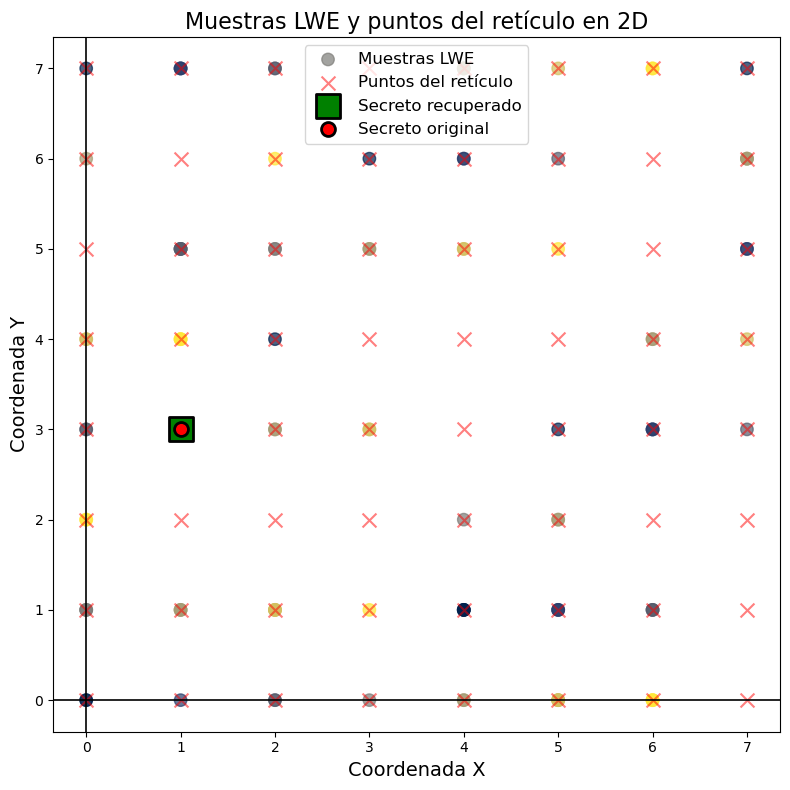

In [14]:
# PROBLEMA LWE EN 2 DIMENSIONES
dim = 2
num_samples = 100
q = 7
noise_stddev = 0

# Generar secreto aleatorio
secret = [random.randint(0, q) for _ in range(dim)]
print(f"El secreto es: {secret}")

# Generar muestras LWE
samples = generate_LWE_samples(secret, num_samples, dim, q, noise_stddev)

# Generar puntos del retículo
lattice_points = list(product(range(0, q + 1), repeat=dim))

# Resolver LWE
recovered_secret = solve_LWE(samples, lattice_points, q, noise_stddev)

# Imprimir el secreto recuperado
if recovered_secret is not None:
    print(f"El secreto recuperado es: {recovered_secret}")
else:
    print("No se encontró solución válida.")

# Separar las coordenadas de las muestras y los puntos del retículo
a_vectors = np.array([sample[0] for sample in samples])
b_values = np.array([sample[1] for sample in samples])
lattice_points = np.array(lattice_points)

# Visualización en 2D
plt.figure(figsize=(8, 8))

# Graficar los vectores 'a' de las muestras con un mapa de colores
scatter1 = plt.scatter(a_vectors[:, 0], a_vectors[:, 1], c=b_values, cmap="cividis", label="Muestras LWE", alpha=0.7, s=80)

# Graficar los puntos del retículo
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], c="red", marker="x", label="Puntos del retículo", alpha=0.5, s=100)

# Agregar el secreto recuperado
if recovered_secret is not None:
    plt.scatter(recovered_secret[0], recovered_secret[1], c="green", marker="s", label="Secreto recuperado", s=300, edgecolors="black", linewidth=2)

# Agregar el secreto original
plt.scatter(secret[0], secret[1], c="red", marker="o", label="Secreto original", s=100, edgecolors="black", linewidth=2)

# Configurar el gráfico
plt.axhline(0, color="black", linewidth=1.2)
plt.axvline(0, color="black", linewidth=1.2)
plt.title("Muestras LWE y puntos del retículo en 2D", fontsize=16)
plt.xlabel("Coordenada X", fontsize=14)
plt.ylabel("Coordenada Y", fontsize=14)

# Leyenda simplificada
plt.legend(fontsize=12)

# Eliminar cuadrícula y barra de colores
plt.grid(False)

plt.tight_layout()
plt.show()


El secreto es: [1, 4, 1]
El secreto recuperado es: (1, 4, 1)


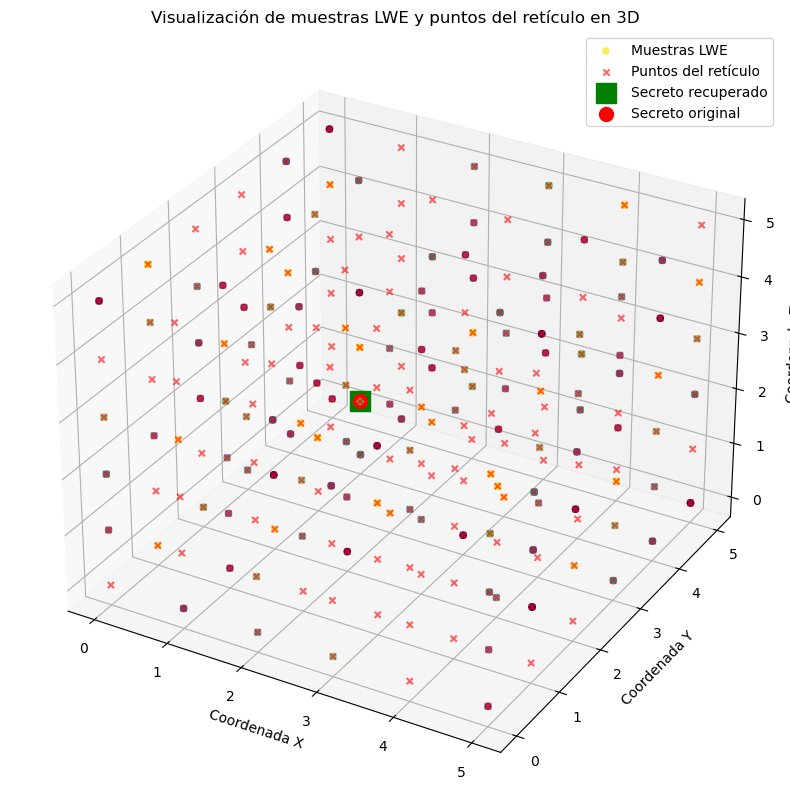

In [15]:
# PROBLEMA LWE EN 3 DIMENSIONES
dim = 3
num_samples = 216
q = 5
noise_stddev = 0

# Generar secreto aleatorio
secret = [random.randint(0, q) for _ in range(dim)]
print(f"El secreto es: {secret}")

# Generar muestras LWE
samples = generate_LWE_samples(secret, num_samples, dim, q, noise_stddev)

# Generar puntos del retículo
lattice_points = list(product(range(0, q + 1), repeat=dim))

# Resolver LWE
recovered_secret = solve_LWE(samples, lattice_points, q, noise_stddev)

# Imprimir el secreto recuperado
if recovered_secret is not None:
    print(f"El secreto recuperado es: {recovered_secret}")
else:
    print("No se encontró solución válida.")

# Separar las coordenadas de las muestras y los puntos del retículo
a_vectors = np.array([sample[0] for sample in samples])
b_values = np.array([sample[1] for sample in samples])
lattice_points = np.array(lattice_points)

# Visualización en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Graficar los vectores 'a' de las muestras
sc = ax.scatter(a_vectors[:, 0], a_vectors[:, 1], a_vectors[:, 2], c=b_values, cmap="viridis", label="Muestras LWE", alpha=0.7)

# Graficar los puntos del retículo
ax.scatter(lattice_points[:, 0], lattice_points[:, 1], lattice_points[:, 2], c="red", marker="x", label="Puntos del retículo", alpha=0.6)

# Agregar el secreto recuperado
if recovered_secret is not None:
    ax.scatter(recovered_secret[0], recovered_secret[1], recovered_secret[2], c="green", marker="s", label="Secreto recuperado", s=200)


# Agregar el secreto original
ax.scatter(secret[0], secret[1], secret[2], c="red", marker="o", label="Secreto original", s=100)


# Configurar el gráfico
ax.set_title("Visualización de muestras LWE y puntos del retículo en 3D")
ax.set_xlabel("Coordenada X")
ax.set_ylabel("Coordenada Y")
ax.set_zlabel("Coordenada Z")
ax.legend()
plt.show()



In [16]:
# PROBLEMA LWE GENERALIZADO

# VARIABLES
num_samples = 100  # Número de muestras
dim = 5     # Dimensión del secreto
q = 31       # Rango máximo de valores en 'a'
noise_stddev = 0   # Desviación estándar del ruido

# Generar secreto aleatorio
secret = [random.randint(0, q) for _ in range(dim)]
print(f"El secreto es: {secret}")

# Generar muestras LWE
samples = generate_LWE_samples(secret, num_samples, dim, q, noise_stddev)

# Generar base ortogonal y puntos del retículo
base = np.eye(dim, dtype=int).tolist()  # Base ortogonal estándar
lattice_points = list(product(range(0, q + 1), repeat=dim))

print(f"Base del retículo: {base}")

# Medir tiempo de ejecución para resolver LWE
start_time = time.time()
recovered_secret = solve_LWE(samples, lattice_points, q, noise_stddev)
end_time = time.time()
    
# Mostrar resultados
if recovered_secret is not None:
    print(f"\nSecreto recuperado correctamente: {recovered_secret}")
else:
    print("\nNo se encontró solución válida.")

print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")


El secreto es: [6, 5, 22, 6, 19]
Base del retículo: [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]

Secreto recuperado correctamente: (6, 5, 22, 6, 19)
Tiempo de ejecución: 7.44 segundos
